In [86]:
import pandas as pd
from typing import List
from scipy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt
from pandas import (
    Timestamp,
)
from scipy.interpolate import RegularGridInterpolator as RGI
import math
df = pd.read_excel('files/smspecs_yearly.xlsx', sheet_name=None,  index_col=0)
class Variant:
    _df:pd.DataFrame=None
    dates:List[Timestamp]=None
    base:'Variant'=None

    @classmethod
    def from_xls_smspecs_yearly(cls, df, key, base=None):
        obj :Variant= cls()
        obj.base = base
        obj.full_name = key
        obj.dates = []
        for bin_var, date_line in zip(key.split('-')[0], key.split('-')[1:]):
            if bin_var == '1':
                if date_line =='xxxx':
                    obj.dates.append(pd.to_datetime('2013-01-01', format='%Y-%m-%d'))
                else:
                    obj.dates.append(pd.to_datetime(f'{date_line}-01-01', format='%Y-%m-%d'))
            else:
                if date_line == 'xxxx':
                    obj.dates.append(pd.to_datetime(f'2031-01-01', format='%Y-%m-%d'))
                else:
                    obj.dates.append(pd.to_datetime(f'{date_line}-01-01', format='%Y-%m-%d'))
        
        obj._df:pd.DataFrame = df / 10**9        
        obj._trendC00 = None
        obj._RGI = None        
        return obj
        
    @property
    def _get_totals_by_event(self)->np.ndarray:
        # return self._df[self._df.index.isin(self.dates)].total.to_numpy()
        # return [None if date is None else self._df.loc[date].total for date in self.dates]
        df_res = pd.DataFrame(index=self.dates,  data={'total':[0]*len(self.dates)})
        return df_res
        
    @property
    def get_borders(self)->pd.DataFrame:
        df_res = pd.merge(self._df, self._get_totals_by_event, left_index=True, right_index=True,how='right')
        df_res = df_res.rename(columns={'total_x':'total'})     
        df_res = df_res.drop(['total_y','yearly'], axis=1)
        df_res = df_res.fillna(math.inf)
        return df_res

    @property
    def name(self) -> int: return int(self.full_name.split('-')[0],base=2)
    def __repr__(self) -> str:
        return '\n'.join([
            repr(self._df),
            f'name={self.name:03b} dates={self.dates}',
            self.full_name
        ])

    @property
    def get_trends(self)->List[RGI]:
        if self._RGI is None:
            self._RGI = []
            df_c = self._df
            min_val = - math.inf
            for cur_total in self.get_borders.total:
                x_ar = df_c[(min_val <= df_c.total) & (df_c.total <cur_total)].total.to_numpy()
                y_ar = df_c[(min_val <= df_c.total) & (df_c.total <cur_total)].yearly.to_numpy()
                if len(x_ar) == 0:
                    # if self.base is None:
                    x_ar = self._df.total.to_numpy()
                    y_ar = self._df.yearly.to_numpy()
                    # else:
                        # x_ar = self.base._df.total.to_numpy()
                        # y_ar = self.base._df.yearly.to_numpy()
                # else:
                if len(x_ar) <= 4:
                    interp = RGI((x_ar,), y_ar, method='linear', bounds_error=False,fill_value=None)
                else:                
                    interp = RGI((x_ar,), y_ar, method='pchip', bounds_error=False,fill_value=None)                
                self._RGI.append(interp)
                
                min_val = cur_total
        return self._RGI

    def get_trend_val(self, val:float)->float:
        for _RGI, total in zip(self.get_trends, self.get_borders.total):
            if val < total:
                return _RGI([val])[0]
        assert True, f'Чо то с трендами, {self}'

    def show(self):
        fig, axs = plt.subplots(ncols=2)
        axs[0].plot(self._df.total, self._df.yearly, '.')
        x_arr = np.linspace(self._df.total.min(), self._df.total.max(), 500)
        axs[0].plot(x_arr, [ self.get_trend_val(x) for x in x_arr])
        axs[0].set_xlim(0)
        # axs[1].set_xlim(0)
        if not self.base is None:
            dq = self.get_dq
            axs[1].plot(dq.x, dq.dq)
        plt.show()

    @property
    def get_dq(self)->pd.DataFrame:
        # x_arr = self.base._df[self.base._df.total > self.get_borders.total[0]].total
        x_arr = self._df[self.base._df.total > self.get_borders.total[0]].total
        return pd.DataFrame({
            'x':x_arr,
            'dq':[
                    self.get_trend_val(total) - self.base.get_trend_val(total)
                for total in x_arr]                
        })
base_var = Variant.from_xls_smspecs_yearly(df['000-xxxx-xxxx-xxxx'],'000-xxxx-xxxx-xxxx') 
arr_vars = [
    Variant.from_xls_smspecs_yearly(df[key],key, base_var)
    for key in filter(lambda k: k != '000-xxxx-xxxx-xxxx', df.keys())]

# base_var

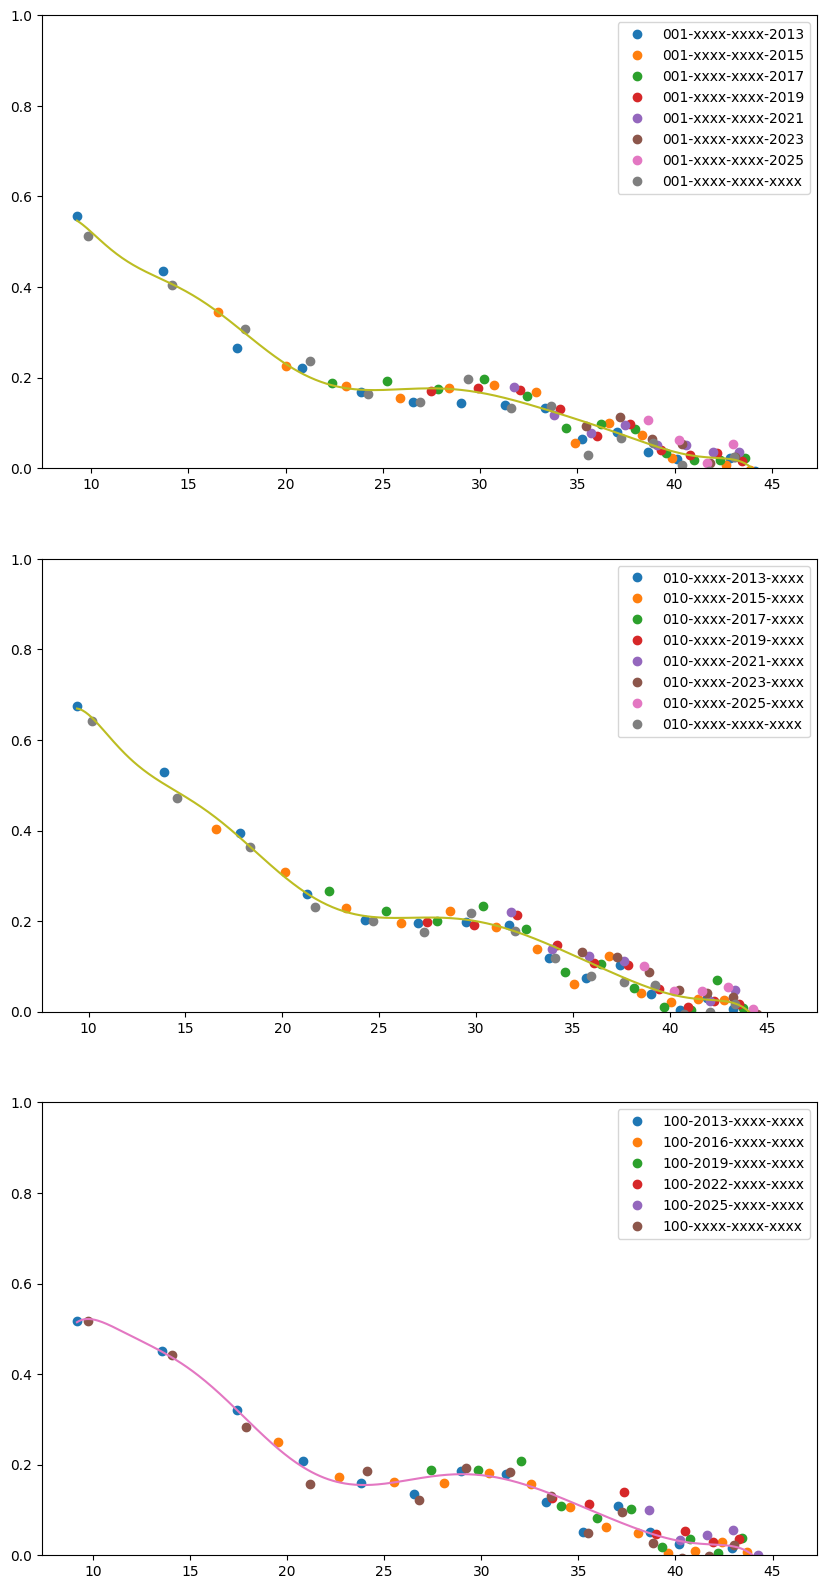

array([ 1.,  1., 16.])

In [93]:
from scipy.interpolate import interp1d
from scipy.interpolate import BarycentricInterpolator as BCI
from typing import Dict
class Proxy:
    _deg = 10
    def __init__(self, arr_Variant:List[Variant]) -> None:
        self.arr_Variant = arr_Variant
        self._polyfit = None
    def get_var_by_name(self,name:int)->pd.DataFrame: return next(filter(lambda x: x.name == name,self.arr_Variant))
    
    @property
    def get_mono_event_datasets(self)->Dict[int,np.ndarray]:
        res = {}
        for num in [1,2,4]:
            x_all = []
            y_all = []
            for var in filter(lambda var: var.name in [num], self.arr_Variant):            
                df = var.get_dq
                x_all.extend(df.x)
                y_all.extend(df.dq)
            res[num] = np.array([x_all, y_all]).T
        return res
    def show(self): 
        fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
        for ax, num in zip(axs,[1,2,4]):
            ax.set_ylim(0)
            for var in filter(lambda var: var.name in [num], self.arr_Variant):            
                df = var.get_dq
                line, = ax.plot(df.x, df.dq, 'o')
                line.set_label(var.full_name)
            x_linspace = np.linspace(ax.dataLim.xmax, ax.dataLim.xmin, 500)
            y_values = self.get_mono_value(num, x_linspace)
            ax.plot(x_linspace, y_values, '-')

        
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        plt.show()
    def get_mono_value(self,num, values)->float:
        if self._polyfit is None:
            self._polyfit = {}
            for key, dataset in self.get_mono_event_datasets.items():

                # self._polyfit[key] = interp1d(*dataset.T)
                self._polyfit[key] =  np.poly1d(np.polyfit(*dataset.T,deg=self._deg))
        return self._polyfit[num](values)
p = Proxy(arr_vars)

# p.get_mono_value(1, [10,20,25, 30])
p.show()
b = BCI([1,2,3],[1,4,9])
b([1,1,4])



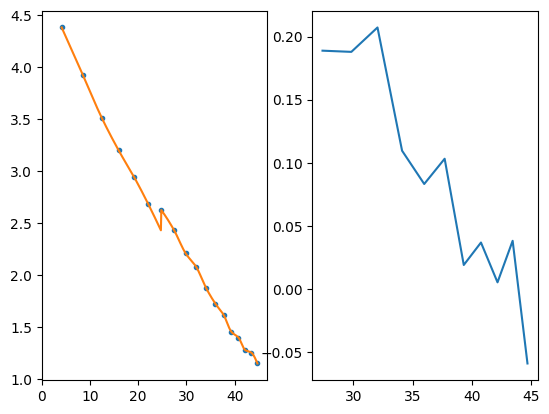

,x,dq
2020-01-01,27.399637,0.188777
2021-01-01,29.832978,0.187829
2022-01-01,32.040454,0.207150
2023-01-01,34.115936,0.109542
2024-01-01,35.985355,0.083195
2025-01-01,37.709324,0.103188
2026-01-01,39.324049,0.019041
2027-01-01,40.775942,0.036834
2028-01-01,42.172514,0.005297
2029-01-01,43.449733,0.038192


In [88]:
name = '100-2019-xxxx-xxxx'
var = next(filter(lambda x: x.full_name == name ,p.arr_Variant))

var.show()
var.get_dq
# [v.full_name for v in p.arr_Variant if v.full_name.split('-')[0] == '100']
# print(var)
# var._get_trends
# var.show()
